In [7]:
from smt.utils.sm_test_case import SMTestCase
from smt.problems import MixedCantileverBeam
from smt.sampling_methods import LHS
from smt.surrogate_models import KRG
from smt.applications.explainability_tools import PartialDependenceDisplay
from smt.utils.design_space import (
    DesignSpace,
    FloatVariable,
    CategoricalVariable,
)
from smt.applications.mixed_integer import MixedIntegerKrigingModel
from smt.surrogate_models import (
    KPLS,
    MixIntKernelType,
    MixHrcKernelType,
)
import numpy as np

In [76]:
ndoe = 100
fun = MixedCantileverBeam()
# Design space
ds = DesignSpace([
    CategoricalVariable(values=[str(i + 1) for i in range(12)]),
    FloatVariable(10.0, 20.0),
    FloatVariable(1.0, 2.0),
])
x = fun.sample(ndoe)
y = fun(x)

# Name of the features
feature_names = [r'$\tilde{I}$', r'$L$', r'$S$']
# Index for categorical features
categorical_feature_indices = [0]
# create mapping for the categories
categories_map = dict()
for feature_idx in categorical_feature_indices:
    categories_map[feature_idx] = {
        i: value for i, value in enumerate(ds._design_variables[feature_idx].values)
    }

sm = MixedIntegerKrigingModel(
    surrogate=KPLS(
        design_space=ds,
        categorical_kernel=MixIntKernelType.HOMO_HSPHERE,
        hierarchical_kernel=MixHrcKernelType.ARC_KERNEL,
        theta0=np.array([4.43799547e-04, 4.39993134e-01, 1.59631650e+00]),
        corr="squar_exp",
        n_start=1,
        cat_kernel_comps=[2],
        n_comp=2,
        print_global=False,
        ),
    )
sm.set_training_values(x, np.array(y))
sm.train()

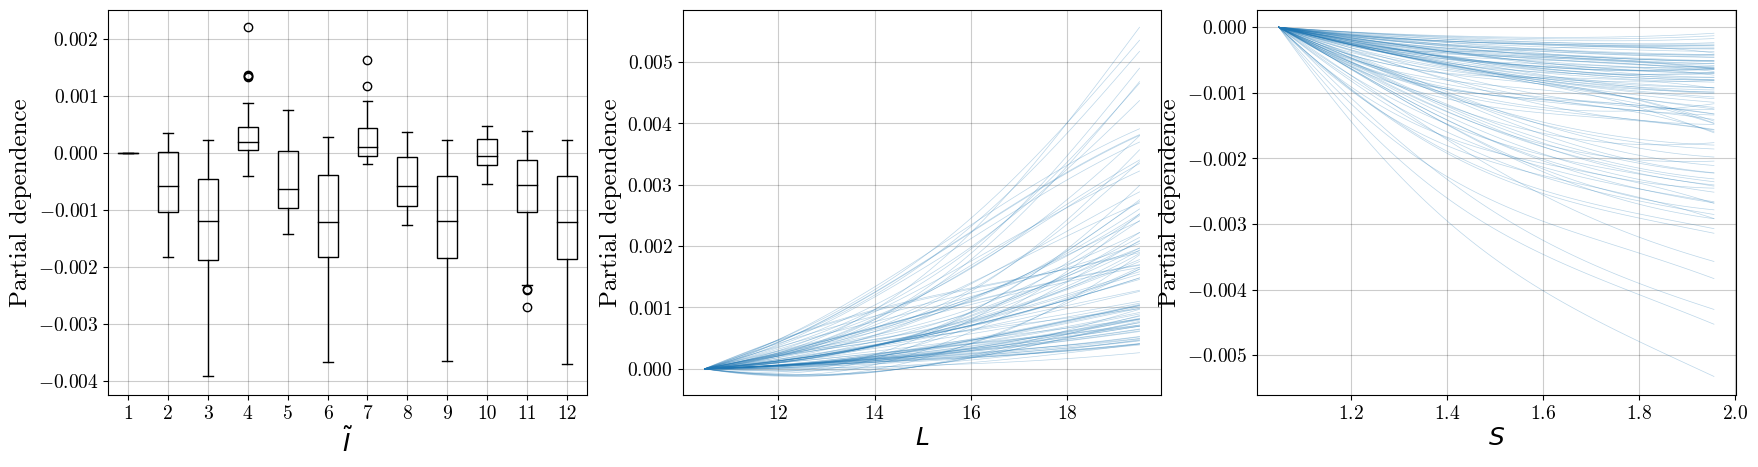

In [53]:
features = [i for i in range(x.shape[1])]
grid_resolution = 100

pdd = PartialDependenceDisplay.from_surrogate_model(
    sm,
    x,
    features,
    feature_names=feature_names,
    kind='individual',
    grid_resolution=grid_resolution,
    categories_map=categories_map,
    categorical_feature_indices=categorical_feature_indices,
)
fig = pdd.plot(centered=True)
fig

In [54]:
pd_results = pdd.pd_results
assert len(pd_results) == len(features)
for i in range(len(pd_results)):
    feature_index = features[i]
    assert len(pd_results[i]["grid_values"]) == 1

    if feature_index in categorical_feature_indices:
        desired_grid_values = np.unique(x[:, feature_idx])
        desired_grid_categories = [categories_map[feature_idx][val] for val in desired_grid_values]

        assert set(pd_results[i].keys()) == {"grid_values", "individual", "grid_categories"}
        assert len(pd_results[i]["grid_categories"]) == 1
        np.testing.assert_array_equal(pd_results[i]["grid_values"][0], desired_grid_values)
        assert pd_results[i]["individual"].shape == (ndoe, len(desired_grid_values))
        assert list(pd_results[feature_idx]["grid_categories"][0]) == desired_grid_categories

    else:
        assert set(pd_results[i].keys()) == {"grid_values", "individual"}
        assert pd_results[i]["grid_values"][0].shape == (grid_resolution, )
        assert pd_results[i]["individual"].shape == (ndoe, grid_resolution)
    


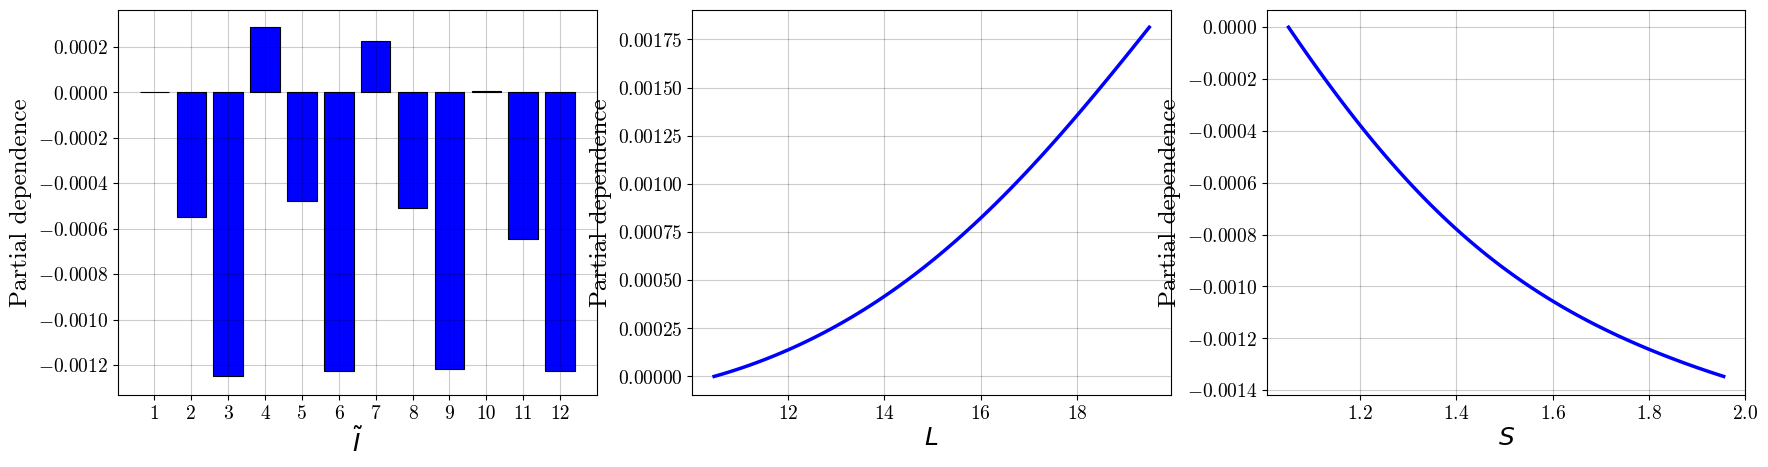

In [44]:
features = [i for i in range(x.shape[1])]
grid_resolution = 100

pdd = PartialDependenceDisplay.from_surrogate_model(
    sm,
    x,
    features,
    feature_names=feature_names,
    kind='average',
    grid_resolution=grid_resolution,
    categories_map=categories_map,
    categorical_feature_indices=categorical_feature_indices,
)
fig = pdd.plot(centered=True)
fig

In [52]:
pd_results = pdd.pd_results
assert len(pd_results) == len(features)
for i in range(len(pd_results)):
    feature_index = features[i]
    assert len(pd_results[i]["grid_values"]) == 1

    if feature_index in categorical_feature_indices:
        desired_grid_values = np.unique(x[:, feature_idx])
        desired_grid_categories = [categories_map[feature_idx][val] for val in desired_grid_values]

        assert set(pd_results[i].keys()) == {"grid_values", "average", "grid_categories"}
        assert len(pd_results[i]["grid_categories"]) == 1
        np.testing.assert_array_equal(pd_results[i]["grid_values"][0], desired_grid_values)
        assert pd_results[i]["average"].shape == (len(desired_grid_values), )
        assert list(pd_results[feature_idx]["grid_categories"][0]) == desired_grid_categories

    else:
        assert set(pd_results[i].keys()) == {"grid_values", "average"}
        assert pd_results[i]["grid_values"][0].shape == (grid_resolution, )
        assert pd_results[i]["average"].shape == (grid_resolution, )

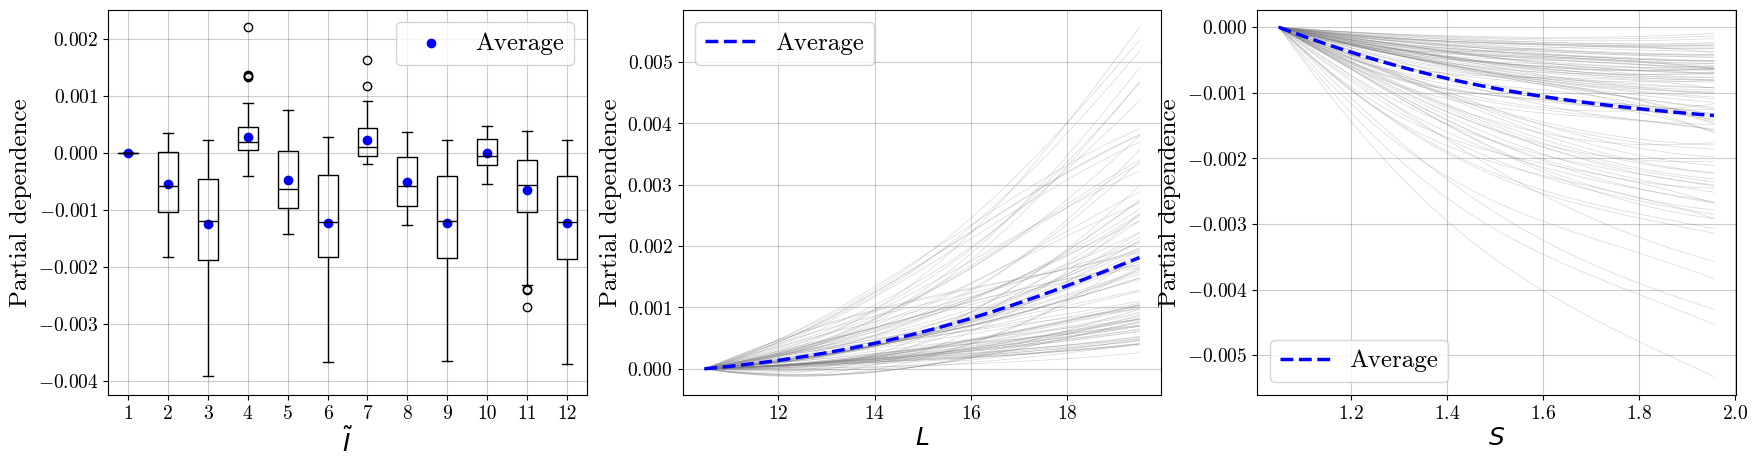

In [55]:
features = [i for i in range(x.shape[1])]
grid_resolution = 100

pdd = PartialDependenceDisplay.from_surrogate_model(
    sm,
    x,
    features,
    feature_names=feature_names,
    kind='both',
    grid_resolution=grid_resolution,
    categories_map=categories_map,
    categorical_feature_indices=categorical_feature_indices,
)
fig = pdd.plot(centered=True)
fig

In [56]:
pd_results = pdd.pd_results
assert len(pd_results) == len(features)
for i in range(len(pd_results)):
    feature_index = features[i]
    assert len(pd_results[i]["grid_values"]) == 1

    if feature_index in categorical_feature_indices:
        desired_grid_values = np.unique(x[:, feature_idx])
        desired_grid_categories = [categories_map[feature_idx][val] for val in desired_grid_values]

        assert set(pd_results[i].keys()) == {"grid_values", "average", "grid_categories", "individual"}
        assert len(pd_results[i]["grid_categories"]) == 1
        np.testing.assert_array_equal(pd_results[i]["grid_values"][0], desired_grid_values)
        assert pd_results[i]["average"].shape == (len(desired_grid_values), )
        assert pd_results[i]["individual"].shape == (ndoe, len(desired_grid_values))
        assert list(pd_results[feature_idx]["grid_categories"][0]) == desired_grid_categories

    else:
        assert set(pd_results[i].keys()) == {"grid_values", "average", "individual"}
        assert pd_results[i]["grid_values"][0].shape == (grid_resolution, )
        assert pd_results[i]["average"].shape == (grid_resolution, )
        assert pd_results[i]["individual"].shape == (ndoe, grid_resolution)

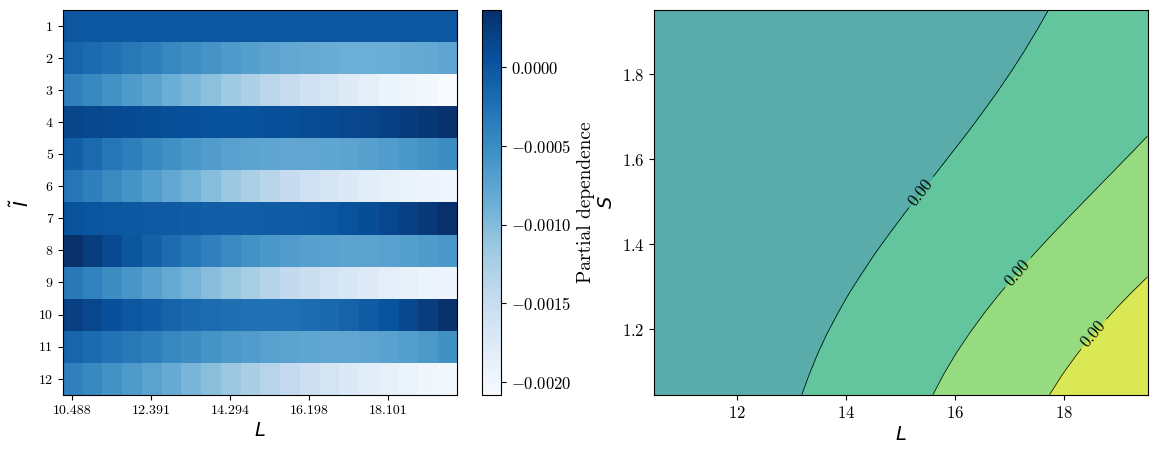

In [79]:
features = [(0, 1), (1, 2)]
grid_resolution = 20
model = sm

pdd = PartialDependenceDisplay.from_surrogate_model(
    model,
    x,
    features,
    feature_names=feature_names,
    categories_map=categories_map,
    categorical_feature_indices=categorical_feature_indices,
    grid_resolution=grid_resolution
)
fig = pdd.plot(centered=True)
fig

In [100]:
pd_results = pdd.pd_results
assert len(pd_results) == len(features)
for i in range(len(pd_results)):
    feature_pair = features[i]
    assert len(pd_results[i]["grid_values"]) == 2

    cat_features = [feature_idx for feature_idx in feature_pair if feature_idx in categorical_feature_indices]
    non_cat_features = [feature_idx for feature_idx in feature_pair if feature_idx not in cat_features]

    if len(cat_features) > 0:
        desired_average_shape = list()
        for feature_idx in feature_pair:
            if feature_idx in cat_features:
                desired_average_shape.append(len(np.unique(x[:, feature_idx])))
            else:
                desired_average_shape.append(grid_resolution)
        desired_average_shape = tuple(desired_average_shape)

        assert set(pd_results[i].keys()) == {"grid_values", "average", "grid_categories"}
        assert len(pd_results[i]["grid_categories"]) == 2
        assert pd_results[i]["average"].shape == desired_average_shape
        
        for j in range(2):
            feature_idx = feature_pair[j]
            if feature_idx in cat_features:
                desired_grid_values = np.unique(x[:, feature_idx])
                desired_grid_categories = [categories_map[feature_idx][val] for val in desired_grid_values]
                np.testing.assert_array_equal(pd_results[i]["grid_values"][j], desired_grid_values)
                assert list(pd_results[i]["grid_categories"][j]) == desired_grid_categories
            else:
                assert pd_results[i]["grid_values"][j].shape == (grid_resolution, )
                assert list(pd_results[i]["grid_categories"][j]) == []
    
    else:
        assert set(pd_results[i].keys()) == {"grid_values", "average",}
        for j in range(2):
            assert pd_results[i]["grid_values"][j].shape == (grid_resolution, )
        assert pd_results[i]["average"].shape == (grid_resolution, grid_resolution)
        